In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

In [3]:
#Initialize some parameters

BETA = np.array([.5,.5])
MU = np.array([.5,.5])
THETA = np.array([.5, .5])
LIST = 1.
COST = 1.

In [19]:
def calc_price(theta,cost,list_price,mu):
    """compute each insurer's price (assumes interior solution)"""
    theta1, theta2 = theta
    mu1, mu2 = mu
    p1 = (2.*theta1*mu1+theta2*mu2)/3. + cost
    p2 = (2.*theta2*mu2+theta1*mu1)/3. + cost
    return np.array([p1,p2])
  
    
def calc_t(theta,cost,list_price,mu):
    """compute the proportion of people choosing each insurer"""
    p1,p2 = calc_price(theta,cost,list_price,mu)
    t = (list_price - p1)/cost,(list_price - p2)/cost
    t = np.clip(t ,0,1) #ensure we are in the right ranges
    t_hat = .5 + (p2 - p1)/(2.*cost)
    t_hat = np.clip([t_hat,1-t_hat],0,1)
    if t[0] >= 1-t[1]: t = t_hat #prevent overlap
    return t


def calc_profits(theta,cost,list_price,mu):
    """compute profits for each firm"""
    p = calc_price(theta,cost,list_price,mu)
    t = calc_t(theta,cost,list_price,mu)
    return t*np.maximum(p-theta*mu,0)


def calc_hosp(theta,cost,list_price,mu):
    """compute profits for hospital"""
    t = calc_t(theta,cost,list_price,mu)
    return np.tile((mu*theta*t).sum(),2)

In [20]:
def outside_option(theta, cost,list_price,mu):
    """compute each firms outside option (i.e. list price)"""
    outside1 =  np.array((list_price,theta[1]))
    outside2 =  np.array((theta[0],list_price))
    
    no_deal1 = calc_profits(outside1,cost,list_price,mu)
    no_deal2 = calc_profits(outside2,cost,list_price,mu)

    return np.array([no_deal1[0], no_deal2[1]]) 


def nash_bargaining(theta,cost,list_price,beta,mu, no_deal=None):
    """compute the nash bargaining objective for both firms"""
    #print 'initial theta: %s'%theta
    theta = np.maximum(np.minimum(theta,list_price),0) #restrict 0 < theta < l
    profits = calc_profits(theta,cost,list_price,mu)
    hosp_profit = calc_hosp(theta,cost,list_price,mu)
    if np.amax([no_deal==None]): no_deal = outside_option(theta, cost,list_price,mu)
    return np.maximum(profits -  no_deal,0)**.5 *np.maximum(hosp_profit,0)**.5

In [21]:
def nash_in_nash(theta_init, theta_fixed, cost,list_price,beta,mu, no_deal):
    """solve the simultaneous objective, holding theta 2 fixed"""
    theta = np.concatenate([theta_init, [theta_fixed]])
    return -nash_bargaining(theta,cost,list_price,beta,mu, no_deal)[0]


def bargain_helper(theta_init, theta_fixed, cost,list_price,beta,mu):
    """solve each firm 1s optimization holding theta 2 fixed"""
    no_deal = outside_option([theta_fixed,theta_fixed],cost,list_price,mu)
    result = minimize(nash_in_nash, theta_init, args=(theta_fixed, cost,list_price,beta,mu,no_deal),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


def simult_bargain(theta_init,cost,list_price,beta,mu):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    theta = theta_init
    diff =  np.abs(np.max(theta - 0)) 
    
    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta_init = theta
        theta1 = bargain_helper(theta[0], theta[1], cost,list_price,beta,mu)
        theta2 = bargain_helper(theta[1], theta1[0], cost,list_price,beta[::-1],mu[::-1])
        
        #update loop variables
        theta = np.concatenate((theta1,theta2))
        diff = np.abs(np.max(theta - theta_init))
        maxiter = maxiter-1
        
    return np.concatenate((theta1, theta2))

In [22]:
def outside_seq(list_price, cost, beta, mu):
    outside_theta =  bargain_helper(list_price, list_price, cost, list_price, beta[::-1],mu[::-1])
    no_deal = calc_profits(np.array([list_price,outside_theta]),cost,list_price,mu)
    return no_deal


def seq_obj(theta_init, cost,list_price,beta,mu,no_deal):
    """ theta2 in the second stage """
    theta_fixed = bargain_helper(theta_init, theta_init[0], cost, list_price, beta[::-1],mu[::-1])
    return nash_in_nash(theta_init, theta_fixed[0], cost,list_price,beta,mu, no_deal)


def seq_bargain(theta_init,cost,list_price,beta,mu):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    no_deal =  outside_seq(list_price, cost, beta, mu)
    result = minimize(seq_obj, theta_init[0], args=(cost,list_price,beta,mu, no_deal),
                      method='Nelder-Mead', options={'disp': False})
    theta1 = result.x
    theta2 = bargain_helper(theta_init[0], theta1[0], cost, list_price, beta[::-1],mu[::-1])
    return np.concatenate((theta1, theta2))

In [23]:
#weird corner case playing around

print seq_bargain(np.array([1.,.2]), 10, 21, np.array([.5,.5]), np.array([.5,.5]))
print '------'
print nash_bargaining([10.80908203, 13.19052734],10,21,BETA,MU)
print nash_bargaining([5.33066784407567, 13.19052734],10,21,BETA,MU)
print '--------'
print calc_profits([10.80908203, 13.19052734],10,21,MU)
print calc_profits([5.33066784407567,13.19052734],10,21,MU)
print '------'
print calc_t([10.80908203, 13.19052734],10,21,MU)
print calc_t([5.33066784407567, 13.19052734],10,21,MU)

[13.19052734 10.80908203]
------
[4.78906155 4.08034963]
[4.59514332 2.54129771]
--------
[5.40478433 4.61096923]
[6.39577852 3.77582535]
------
[0.51984538 0.48015462]
[0.56549883 0.43450117]


In [28]:
print nash_bargaining([1.139,5.970],10,15,[.5,.5],[.5,.5], no_deal=None)
print calc_profits(np.array([1.139,5.970]),10,15,MU)
print '---------'
print  simult_bargain(np.array([2.87,2.87]),10,15,MU,BETA)
print nash_bargaining(np.array([2.80,2.80]),10,15,MU,BETA)
print nash_bargaining(np.array([2.87,2.87]),10,15,MU,BETA)
print '---------'
print seq_bargain(np.array([2.80,2.80]),10,15,MU,BETA)
print nash_bargaining(np.array([1.218,3.818]),10,15,MU,BETA)
print calc_profits(np.array([1.218,3.818]),10,15,MU)

[2.02641724 1.64872598]
[3.91723309 2.59309625]
---------
[2.79846717 2.79845427]
[1.90494094 1.90494094]
[1.90985538 1.90985538]
---------
[1.21679687 3.82040039]
[1.94249897 1.7552883 ]
[4.12916556 3.37161222]


In [11]:
def setup_grid(min_arg, max_arg, no_step):
    """set up grid for numerical approximation"""
    grid = np.arange(no_step)
    
    #multi_dimensial paramters
    if type(min_arg) == np.ndarray:
        grid = grid.reshape(len(grid),1)
        grid = np.tile(grid,(1,2))
    
    scale = (max_arg-min_arg)/(no_step-1.)
    grid = grid*scale+min_arg
    return grid

In [12]:
def make_row(theta,g,cost,list_price,mu):
    """setup a row in the table"""
    
    if type(g) == np.ndarray: #g is the value of the parameter
        g = g[0] #only focus on first entry
        
    g_col = np.array([g])
    profit = calc_profits(theta,cost,list_price,mu)
    hosp = np.array([calc_hosp(theta,cost,list_price,mu)[0]])
    mkt_share = calc_t(theta,cost,list_price,mu)
    row = np.concatenate((g_col,theta,profit,hosp,mkt_share))
    return row


def make_table(arg_no, min_arg, max_arg, no_step, 
               params = [THETA, COST, LIST, BETA, MU] ):
    """make tables for write up by varying the parameters"""
    
    params = params[:] #running into trouble with global variables
    grid = setup_grid(min_arg, max_arg, no_step )
    table = []
    
    for g in grid:
        params[arg_no] = g
        theta,cost,list_price,beta,mu = params
        
        #calculate simult bargain outcome
        theta_simult = simult_bargain(theta,cost,list_price,beta,mu)
        row_simult = make_row(theta_simult,g,cost,list_price,mu)
        table.append(row_simult)
        
        #calculate sequential outcome
        theta_seq = seq_bargain(theta,cost,list_price,beta,mu)
        row_seq = make_row(theta_seq,g,cost,list_price,mu)
        table.append(row_seq)
    return np.array(table)


def write_table(variable, table):
    """write table to file in a pretty way"""
    fname = 'sheets/%s_table.csv'%variable
    f = open(fname, "w+")
    f.write('eq_type,%s,mc1,mc2,profit1,profit2,hosp_profit,share1,share2\n'%variable)
    for i in range(len(table)):
        row = tuple(table[i])
        
        #set row label
        label = 'Simultaneous,'
        if i%2 == 1: label = 'First Mover,'
            
        pretty_row = label +'%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f\n'%tuple(row)
        f.write(pretty_row)        
    f.close()

In [22]:
#reinitialize parameters
BETA = np.array([.5,.5])
MU = np.array([.5,.5])
THETA = np.array([.5, .5])

PARAMS_1 =[THETA, 10, 30, BETA, MU]
PARAMS_2 =[THETA, 10, 30, BETA, MU]

#list price
list_table = make_table(2, 22, 32, 11, params=PARAMS_1)
write_table('list_price', list_table)
    
#lambda
costs_table = make_table(1, 7, 12, 11, params=PARAMS_1)
write_table('distance_cost', costs_table)

#illness probability
#ill_table = make_table(4, np.array([.1,.5]), np.array([1.,.5]), 10, params=PARAMS_2)
#write_table('illness_probability', ill_table)

In [23]:
#hard code column names (for purposes of creating indexes)

COLNAMES = ['',              #0  - parameter
            'Simultaneous',  #1  - mc1
            'Simultaneous',  #2  - mc2
            'Simultaneous',  #3  - profit1
            'Simultaneous',  #4  - profit2
            'Simultaneous',  #5  - hosp_proft
            'Simultaneous',  #6  - share1
            'Simultaneous',  #7  - share2
            '',              #8  - parameter (duplicate)
            'First Mover',   #9  - mc1
            'Second Mover',  #10 - mc2
            'First Mover',   #11 - profit1
            'Second Mover',  #12 - profit2
            'First Mover',   #13 - hosp_proft 
            'First Mover',   #14 - share1
            'Second Mover' ] #15 - share2

In [24]:
def plot_table(table,labels,indexes):
    """quick code for graphing things"""
    length, width = table.shape
    table_plot = table.reshape(length/2,width*2)
    title = '%s vs %s'%labels
    
    #set up labels
    fig = plt.figure()
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    for i in indexes:
        plt.plot(table_plot[:,0],table_plot[:,i],label=COLNAMES[i])
    plt.legend()
    
    #set up file names
    fname = 'plots/%s'%(title)
    fname = ( fname.replace(' ', '_') ).lower()
    fig.savefig(fname)

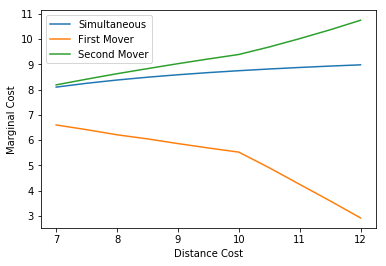

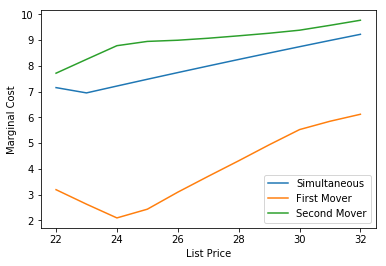

In [26]:
#plotting various theta's
plot_table(costs_table, ('Distance Cost','Marginal Cost'), [1,9,10])
plot_table(list_table, ('List Price','Marginal Cost'),[1,9,10])
#plot_table(ill_table, ('Illness Probability','Marginal Cost'),[1,9,10])

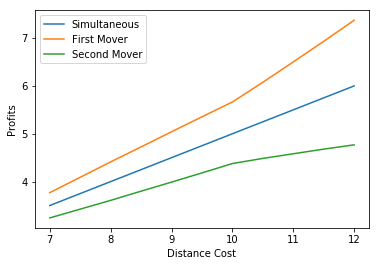

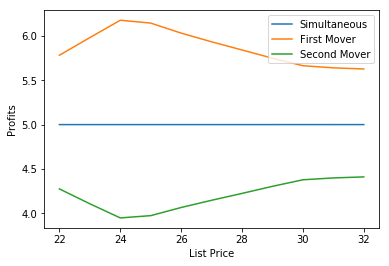

In [27]:
#plotting various pi's
plot_table(costs_table, ('Distance Cost','Profits'), [4,11,12])
plot_table(list_table, ('List Price','Profits'),[4,11,12])
#plot_table(ill_table, ('Illness Probability','Profits'),[4,11,12])

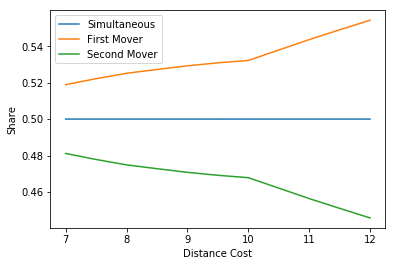

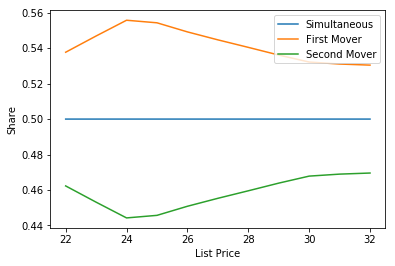

In [28]:
#plotting various market shares
plot_table(costs_table, ('Distance Cost','Share'), [6,14,15])
plot_table(list_table, ('List Price','Share'),[6,14,15])
#plot_table(ill_table, ('Illness Probability','Share'),[6,14,15])

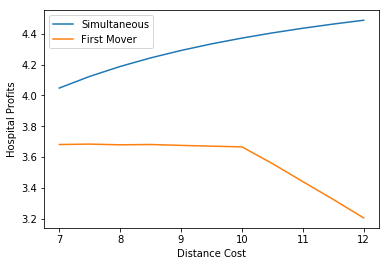

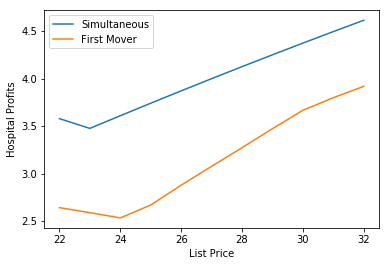

In [29]:
#hospital profits
plot_table(costs_table, ('Distance Cost','Hospital Profits'), [5,13])
plot_table(list_table, ('List Price','Hospital Profits'),[5,13])
#plot_table(ill_table, ('Illness Probability','Hospital Profits'),[5,13])